<a href="https://colab.research.google.com/github/juandesages/PDI.Entregas/blob/main/TP7/TP7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TP7 PROCESAMIENTO MORFOLÓGICO
Desarrollar un aplicativo que permita abrir una imagen y automáticamente convertirla a niveles de grises (en caso de no estarlo) y visualizarla. Con esta imagen se aplicarán los siguientes filtros morfológicos, los cuales deben poderse seleccionar de una lista:
- Erosión (tomar el mínimo valor de luminancia de la vecindad).
- Dilatación (máximo)
- Apertura
-Cierre
- Borde morfológico (frontera interna y externa)
- Mediana
- Top-hat
El elemento estructurante será de una ventana de 3x3 pixeles.
El aplicativo debe incluir una función de copiado de la imagen procesada, de tal manera que esta pueda tomarse como imagen de entrada para así poder aplicar dos o más filtros en secuencia.
El resultado del filtro debe poder guardarse como una nueva imagen en nivel de grises.
Adicionalmente se debe mostrar un plot con el resultado respectivo para cada uno de los filtros indicados.
Nota: La función que desarrollaron para la convolución es la misma que pueden usar para recorrer toda la imagen y aplicar el filtro morfológico.
FECHA DE ENTREGA: 26 DE NOVIEMBRE

In [ ]:
import imageio
import numpy as np 
from scipy import fftpack
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from mpl_toolkits.axes_grid1 import make_axes_locatable
#--------- TPN 1 ---------
#Cargar imagen
def load_image(filename):
    im_in= np.clip(imageio.imread(filename)/255.,0.,1.).astype(np.float)
    #imagen normalizada
    if len(im_in.shape)==2:
      image_type = 'grayscale'
    
    if len(im_in.shape)==3: # la imagen es de tipo RGB
      image_type = 'RGB'
    
    return im_in, image_type

#obtener información de la imagen
def get_data(im, im_type):
  if im_type == 'grayscale':
    h,w, ch = im.shape
    ch = 1
  else:
    h,w, ch = im.shape
  return h,w,ch #height, wide, channels

#guardar imagen
def save_image(im, title):
  im = im*255
  imageio.imwrite(title,im.astype(np.uint8))
  return 

#graficar imagen (mostrar imagen)
def show_image(im, title):
  plt.imshow(im)
  plt.title(title)
  plt.show()
  return 

#--------- TPN 2 ---------
#matriz para transformar de RGB a YIQ
MAT_YIQ = np.array([[0.299, 0.595716, 0.211456],
                    [0.587, -0.274453, -0.522591],
                    [0.114, -0.321263, 0.311135]])
#funcion para pasar una imagen RGB a YIQ
def rgb2yiq(_im):
    _yiq = np.matmul(_im.reshape((-1,3)), MAT_YIQ).reshape(_im.shape)
    return _yiq
#funcion para modificar valores de Y y de IQ
def scale_yiq(_yiq, alpha, beta):
    _yiq[:, :, 0] *= alpha
    _yiq[:, :, 1:3] *= beta   
    return _yiq
#funcion para pasar la imagen de YIQ a RGB
def yiq2rgb(_yiq):
    _rgb = np.matmul(_yiq.reshape((-1,3)),np.linalg.inv(MAT_YIQ)).reshape(_yiq.shape)
    return _rgb

def clip_rgb(rgb):
  return np.clip(rgb, a_min=[0,-0, 0], a_max=[255, 255, 255])

def clip_yiq(yiq):
  return np.clip(yiq, a_min=[0,-0.5957, -0.5226], a_max=[1, 0.5957, 0.5226])

#--------- TPN 3 ---------

def padding(im1, im2):
  f1,c1, _ = im1.shape
  f2,c2, _ = im2.shape
  if f1>f2: fmax = f1
  else: fmax = f2
  if c1>c2: cmax = c1
  else: cmax = c2
  im1_new = np.zeros((fmax,cmax,3), dtype='float')
  im2_new = np.copy(im1_new)
  im1_new[:f1,:c1,:] = im1[:,:,:]
  im2_new[:f2,:c2,:] = im2[:,:,:]
  return im1_new, im2_new
#--------- TPN5 -------------
def fft2_ap(im):
    im_f = np.fft.fftshift(np.fft.fft2(im))
    amp = np.abs(im_f)
    phase = np.angle(im_f)
    # amplitud normalizada:
    s = np.array(im.shape).prod()
    amp /= s
    return amp, phase

def ifft2_ap(amp, phase):
    s = np.array(amp.shape).prod()
    im_f = s * amp * (np.cos(phase)+1j *np.sin(phase))
    im = np.fft.ifft2(np.fft.ifftshift(im_f))
    return im.real
# guardar mapa de bits en png
def ap_to_8bit(amp, phase, fac = 2**24):
    amp_8bit = np.round((np.log(amp*fac+1)/np.log(fac+1)*(2**8))).astype(np.uint8)
    phase_8bit = ((phase/np.pi+1)/2 * 2**8).astype(np.uint8)
    return amp_8bit, phase_8bit

# leer mapa de bits desde un png
def ap_from_8bit(amp_8bit, phase_8bit, fac= 2**24):
    amp = (np.exp(amp_8bit / (2**8) * np.log(fac+1))-1)/fac
    phase = (phase_8bit / 2**8 * 2 - 1)*np.pi
    return amp, phase

#--------- TPN 4 ---------

#--------- TPN 5 ---------

#--------- TPN 6 ---------

def kernel_plot(data):
    s = data.shape
    y, x = np.meshgrid(np.arange(s[0]),np.arange(s[1]),indexing='ij')
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    _min = np.min(data)
    _max = np.max(data)
    ax.plot_surface(x,y,data.T,vmin=_min,vmax=_max)

def convolution(image, kernel = np.ones((1,1))):
    convolved = np.zeros((np.array(image.shape)-np.array(kernel.shape)+1))
    for x, y in np.ndindex(convolved.shape):
        convolved[x,y] = (image[x:x+kernel.shape[0],y:y+kernel.shape[1]]*kernel).sum()
    return convolved
def plain (s=7):
  k = np.ones((s,s))
  return k / k.sum()

def bartlett(s=3):
    a = (s+1)//2-np.abs(np.arange(s)-s//2)
    k = np.outer(a,a.T)
    return k / k.sum()

def gauss(s=3,scale=1):
    g = signal.gaussian(s,scale)
    k = np.outer(g,g.T)
    return k / k.sum()

def box(s=3,scale = None):
    if scale is None:
        scale = s
    padl = (s-scale)//2
    padr = (s-scale)-padl
    k = np.pad(np.ones((s,s)),(padl,padr))
    return k / k.sum()

def circle(s=3,scale=None,n=10):
    if scale is None:
        scale = s
    a = np.linspace(-1+1/(s*n),1-1/(s*n),s*n) *  s / scale 
    sel = ((a[:, np.newaxis]**2 + a[np.newaxis, :]**2)<=1)*1.0
    k = np.zeros((s,s))
    for x in range(s):
        for y in range(s):
            k[y,x] = (sel[y*n:(y+1)*n,x*n:(x+1)*n]).sum()
    return k / k.sum()

def laplace(_type=4,normalize=False):
    if _type==4:
        k =  np.array([[0.,-1.,0.],[-1.,4.,-1.],[0.,-1.,0.]])
    if _type==8:
        k =  np.array([[-1.,-1.,-1.],[-1.,8.,-1.],[-1.,-1.,-1.]])
    if normalize:
        k /= np.sum(np.abs(k))
    return k

def pascal(s=3):
    def pascal_triangle(steps,last_layer = np.array([1])):
        if steps==1:
            return last_layer
        next_layer = np.array([1,*(last_layer[:-1]+last_layer[1:]),1])
        return pascal_triangle(steps-1,next_layer)
    a = pascal_triangle(s)
    k = np.outer(a,a.T)
    return k / k.sum()

def diff_kernel(kernel_in,normalized = False):
    s = kernel_in.shape
    w_x =np.arange(-(s[1]-1)/2,s[1]/2)
    w_y =np.arange(-(s[0]-1)/2,s[0]/2)
    y,x = np.meshgrid(w_y,w_x,indexing='ij')
    k_x = kernel_in * x
    k_y = kernel_in * y
    if normalized:
        k_x /= np.abs(k_x).sum()
        k_y /= np.abs(k_y).sum()
    return (k_x, k_y)

def sobel(s=3):
    return diff_kernel(pascal(s))

def identity_kernel(s):
    kernel = np.zeros(s)
    kernel[s[0]//2,s[1]//2] = 1.
    return kernel
    
def high_pass(low_pass):
    return identity_kernel(low_pass.shape) - low_pass

def dog(size,fs=1,cs=2):
    return gauss(size,fs)-gauss(size,cs)

#--------- TPN 7 ---------

# elementos estructurales

def box(r):
    se = np.ones((r*2+1,r*2+1),dtype=np.bool)
    return se

def circle(r, threshold = 0.3):
    vec = np.linspace(-r, r, r*2+1)
    [x,y] = np.meshgrid(vec,vec) 
    se = (x**2 + y**2)**0.5 < (r + threshold)
    return se
# procesamiento morfológico en escala de grises
def _morph_gray(im, se, op):

    result = np.zeros(im.shape)
    offset = (np.array(se.shape)-1)//2
    im = np.pad(im,[(offset[0],offset[0]),(offset[1],offset[1])],'edge')
    for y, x in np.ndindex(result.shape):
        pixels = im[y: y + se.shape[0], x: x + se.shape[1]][se]
        result[y, x] = op(pixels)
    return result

# funciones
def im_dilate(im, se):
    return _morph_gray(im, se, np.max)
    
def im_erode(im, se):
    return _morph_gray(im, se, np.min)

def im_open(im, se):
    return im_dilate(im_erode(im, se), se)

def im_close(im, se):
    return im_erode(im_dilate(im, se), se)
    
def im_border_ext(im, se):
    return im_dilate(im, se) - im

def im_border_int(im, se):
    return im - im_erode(im, se)

def im_median(im, se):
    return _morph_gray(im, se, np.median)

def im_tophat(im,se):
    return im - im_open(im,se)

  




(220, 325, 4)
(220, 325, 3)


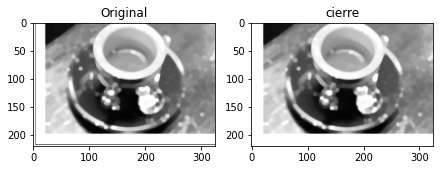

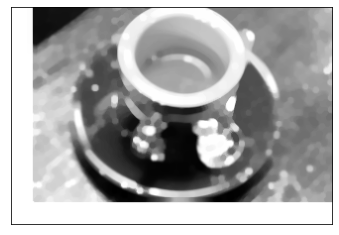

In [ ]:
#@title _Cargar imagen_ seleccione la imagen que desea procesar y el tipo de procesamiento

imagen = 'anterior'  #@param ['imageio:astronaut.png','imageio:camera.png','imageio:checkerboard.png', 'imageio:chelsea.png', 'imageio:coffee.png','imageio:wikkie.png', 'anterior']
procesamiento = 'cierre' #@param ['erosion','dilatacion', 'apertura', 'cierre', 'borde externo', 'borde interno', 'mediana', 'top hat' ]
if imagen != 'anterior': 
  im, im_type = load_image(imagen)
  if im_type != 'grayscale':
    _im = rgb2yiq(im)
    im = _im[:,:,0]
    
if imagen == 'anterior':
  im = np.clip(mpimg.imread('anterior.png')/255.,0.,1.).astype(np.float)
  print(im.shape)
  fmax, cmax, ch = im.shape
  img = np.zeros((fmax,cmax,3), dtype='float')
  img = (im[:,:,:3])
  print(img.shape)
  _im = rgb2yiq(img)
  im = _im[:,:,0]

se = circle(2)

if procesamiento == 'erosion' :
  im_processed = im_erode(im, se)

if procesamiento == 'dilatacion' :
  im_processed = im_dilate(im, se)

if procesamiento == 'apertura' :
  im_processed = im_open(im, se)

if procesamiento == 'cierre' :
  im_processed = im_close(im, se)

if procesamiento == 'borde externo' :
  im_processed = im_border_ext(im, se)

if procesamiento == 'borde interno' :
  im_processed = im_border_int(im, se)

if procesamiento == 'mediana' :
  im_processed = im_median(im, se)

if procesamiento == 'top_hat' :
  im_processed = im_tophat(im, se)

fig, ax = plt.subplots(1, 2, constrained_layout=True)
original =ax[0].imshow(im, cmap = 'gray')
ax[0].set_title('Original')
processed = ax[1].imshow(im_processed, cmap = 'gray')
ax[1].set_title(str(procesamiento))
plt.savefig(str(procesamiento)+'.png')
plt.show()

fig = plt.imshow(im_processed, cmap = 'gray')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('anterior.png',bbox_inches='tight',transparent=True, pad_inches=0)
plt.show()


Al realizar el procesamiento morfologico de las imagenes precargadas podemos ver que se comporta acorde a lo visto en clase. Teniendo en cuenta que si la imagen es RGB debemos convertirla al espacio YIQ y sólo analizar la luminancia.
Se muestran tanto la imagen original como la procesada para compararlas. Ademas se muestra y se guarda en el archivo anterior.png para poder realizar combinaciones de procesamientos y ver los resultados. (teniendo en cuenta que la imagen se va "achicando" por el padding empleado que deja una fila y una columna en blanco
